# Forecasting Wearing-off

References:
* [Machine Learning Mastery's Time Series Tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
* [Tensorflow's Time Series Tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)


# Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score

# Load configuration

In [2]:
# Participant to process
USER = 'participant1'
# USER = f'participant{sys.argv[1]}'

# Collection dataset
COLLECTION = '2-person'
# COLLECTION = '10-person'

# Define base path
BASE_DATA_PATH = '/workspaces/abc2023/data'

In [3]:
# Choose features
# Garmin features
features = ['heart_rate', 'steps', 'stress_score',
            'awake', 'deep', 'light', 'rem',
            'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# FonLog features
features += ['time_from_last_drug_taken', 'wo_duration']

# Additional features
features += ['timestamp_hour', 'timestamp_dayofweek',
             'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

# Normalize features
normalize_features = features

In [4]:
# Metrics & Other Hyperparameters
SHIFT = 4
RECORD_SIZE_PER_DAY = 96  # 60 minutes / 15 minutes * 24 hours

# Load dataset

In [5]:
# Load participant's Excel file
dataset = pd.read_excel(f'{BASE_DATA_PATH}/{COLLECTION}/combined_data.xlsx',
                        index_col="timestamp",
                        usecols=columns,
                        engine='openpyxl')

# Fill missing data with 0
dataset.fillna(0, inplace=True)

# Filter by participant
dataset = dataset.query(f'participant == "{USER}"').drop(
    columns=['participant'])

# Visualize dataset

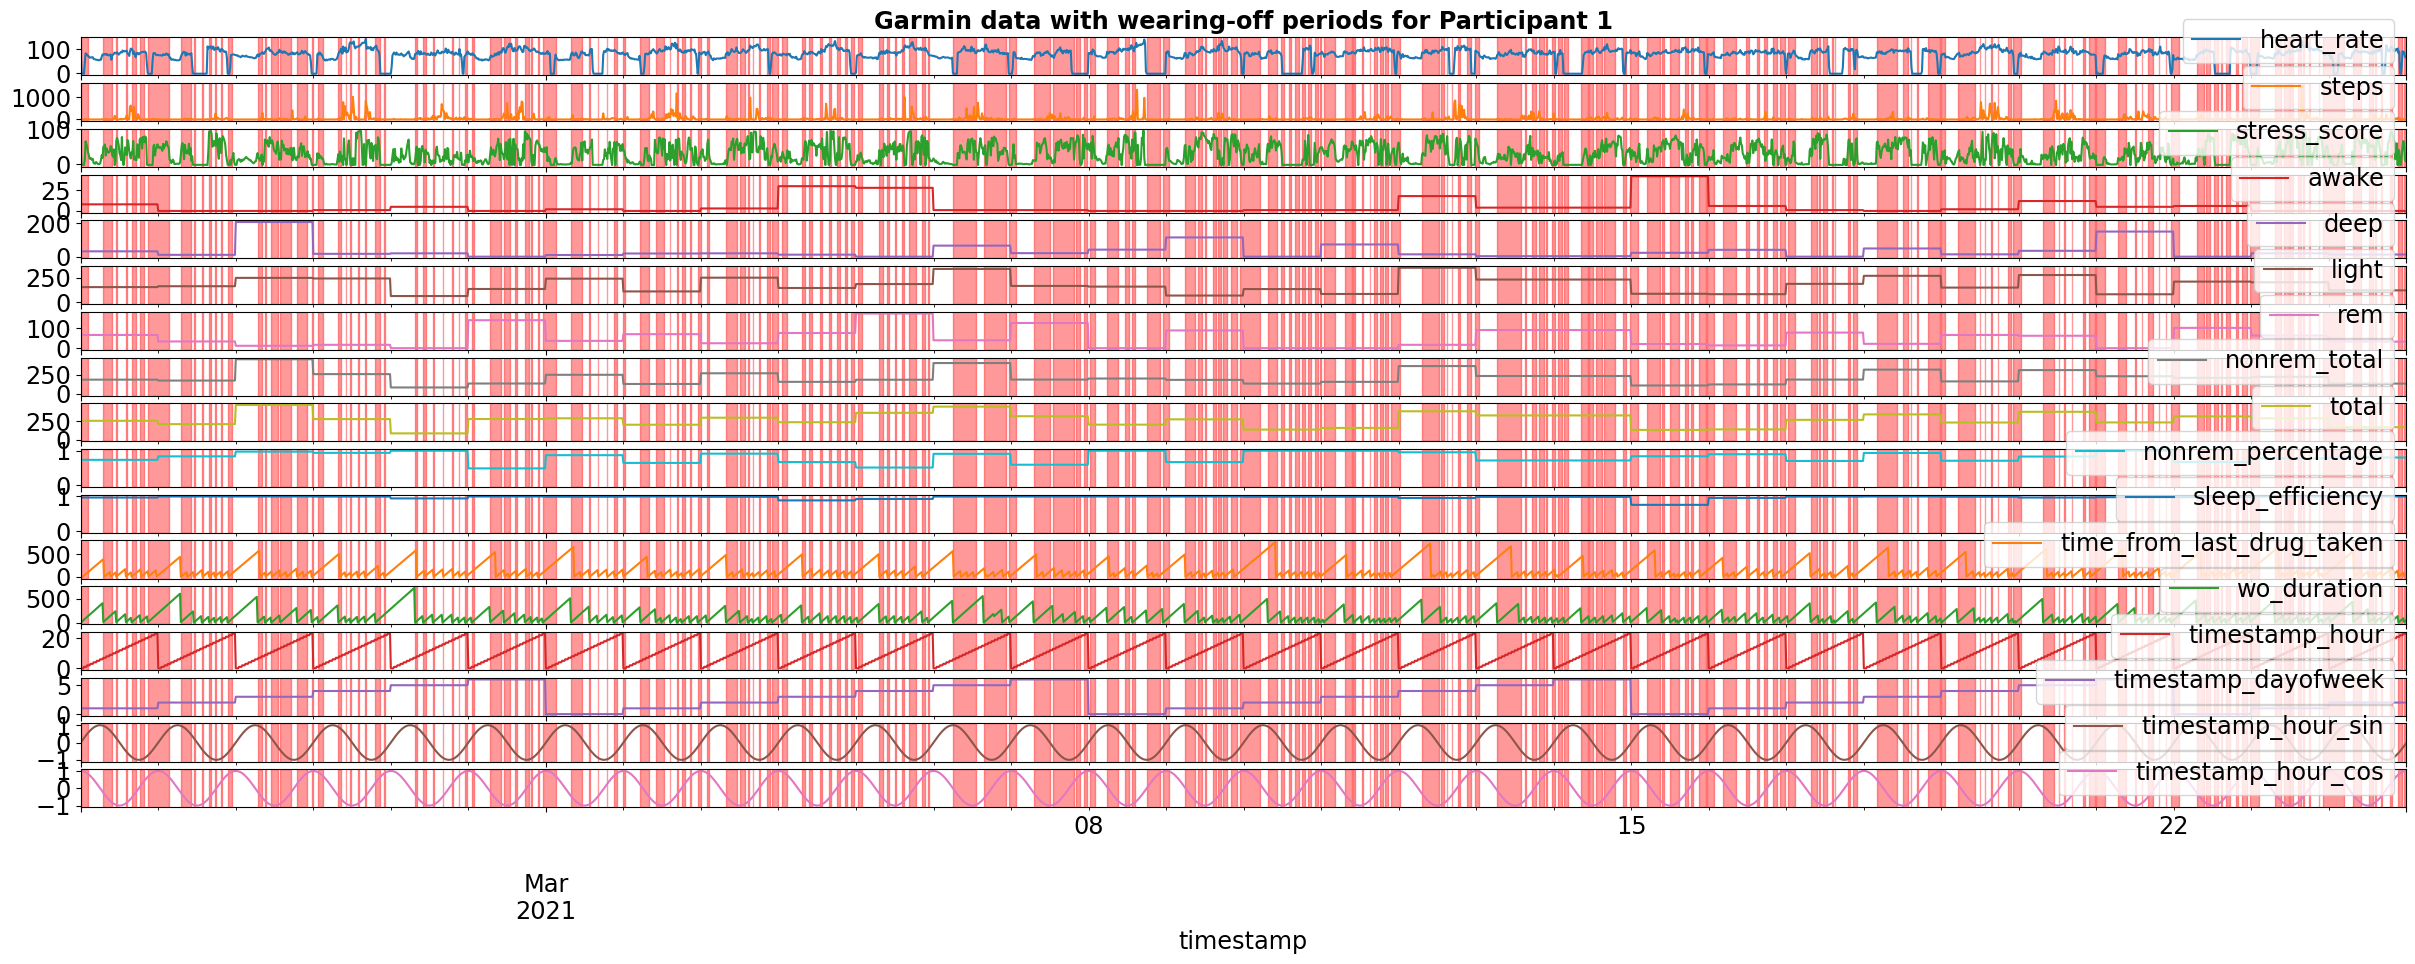

In [6]:
FIGSIZE = (30, 10)

# Garmin features
features_to_visualize = ['heart_rate', 'steps', 'stress_score',
                         'awake', 'deep', 'light', 'rem',
                         'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# FonLog features
features_to_visualize += ['time_from_last_drug_taken', 'wo_duration']

# Additional features
features_to_visualize += ['timestamp_hour', 'timestamp_dayofweek',
                          'timestamp_hour_sin', 'timestamp_hour_cos']

axes = dataset.loc[:, features_to_visualize].plot(
  subplots=True, figsize=FIGSIZE)
for index, axis in enumerate(axes):
  if index == 0:
    axis.set_title(
      label='Garmin data with wearing-off periods for Participant {}'.format(
        USER.replace("participant", "")
      ),
      fontdict={
        'fontsize': 'xx-large',
        'fontweight': 'bold'
      }
    )

  column = dataset.columns[index]
  min_value = dataset[[column]].min()
  max_value = dataset[[column]].max()

  if min_value.values[0] > 0:
    min_value = 0

  axis.fill_between(
      x=dataset.index, y1=min_value, y2=max_value,
      where=dataset.wearing_off,
      alpha=0.4, color="red", transform=axis.get_xaxis_transform()
  )
  axis.legend([column], loc="lower right", fontsize='xx-large')
  axis.tick_params(axis='both', which='both', labelsize='xx-large')
  axis.set_xlabel(xlabel=dataset.index.name, fontsize='xx-large')

plt.show()

# Split dataset into train and test sets

## Split by cross-validation

In [7]:
# Split dataset by number of records
class WindowTimeSeriesSplit():
  def __init__(self, train_size, test_size, is_expanding=False):
    self.train_size = train_size
    self.test_size = test_size
    self.is_expanding = is_expanding

  def get_n_splits(self, X, y, groups):
    n_splits = 0

    n_records = int(len(X))
    indices = np.arange(n_records)

    margin = 0  # Gap between train and test data
    start = 0
    mid = None
    stop = None
    while True:
      if mid is None:
        mid = start + self.train_size
      elif mid is not None:
        if self.is_expanding:
          start = 0
        else:
          start = mid
        mid = mid + self.train_size
      stop = mid + self.test_size
      if start >= n_records or mid >= n_records or stop > n_records:
        break
      else:
        n_splits += 1
    return n_splits

  def split(self, X, y=None, groups=None):
    n_records = int(len(X))
    indices = np.arange(n_records)

    margin = 0  # Gap between train and test data
    start = 0
    mid = None
    stop = None
    while True:
      if mid is None:
        mid = start + self.train_size
      elif mid is not None:
        if self.is_expanding:
          start = 0
        else:
          start = mid
        mid = mid + self.train_size
      stop = mid + self.test_size
      if start >= n_records or mid >= n_records or stop > n_records:
        break
      else:
        print(start, mid, stop)
        yield indices[start: mid], indices[mid + margin: stop]

In [8]:
# Plot cross-validation indices
def plot_cv_indices(cv, X, y, ax, n_splits=0, lw=20):
  """Create a sample plot for indices of a cross-validation object."""

  # Generate the training/testing visualizations for each CV split
  for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
    # Fill in indices with the training/test groups
    indices = np.array([np.nan] * len(X))
    indices[tt] = 1
    indices[tr] = 0

    # Visualize the results
    ax.scatter(range(len(indices)), [ii + .5] * len(indices),
               c=indices, marker='_', lw=lw, cmap=plt.cm.coolwarm,
               vmin=-.2, vmax=1.2)

  n_splits = ii + 1

  # Plot the data classes and groups at the end
  ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y.values,
             marker='_', lw=lw, cmap=plt.cm.Paired)

  # Formatting
  yticklabels = list(range(n_splits)) + ['wearing-off']
  ax.set(yticks=np.arange(n_splits + 1) + .5, yticklabels=yticklabels,
         xlabel='Records\'s Index', ylabel="Folds",
         ylim=[n_splits + 1.2, -.2], xlim=[0, len(X)])
  ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
  return ax

0 192 384
0 384 576
0 576 768
0 768 960
0 960 1152
0 1152 1344
0 1344 1536
0 1536 1728
0 1728 1920
0 1920 2112
0 2112 2304
0 2304 2496
0 2496 2688
0 2688 2880


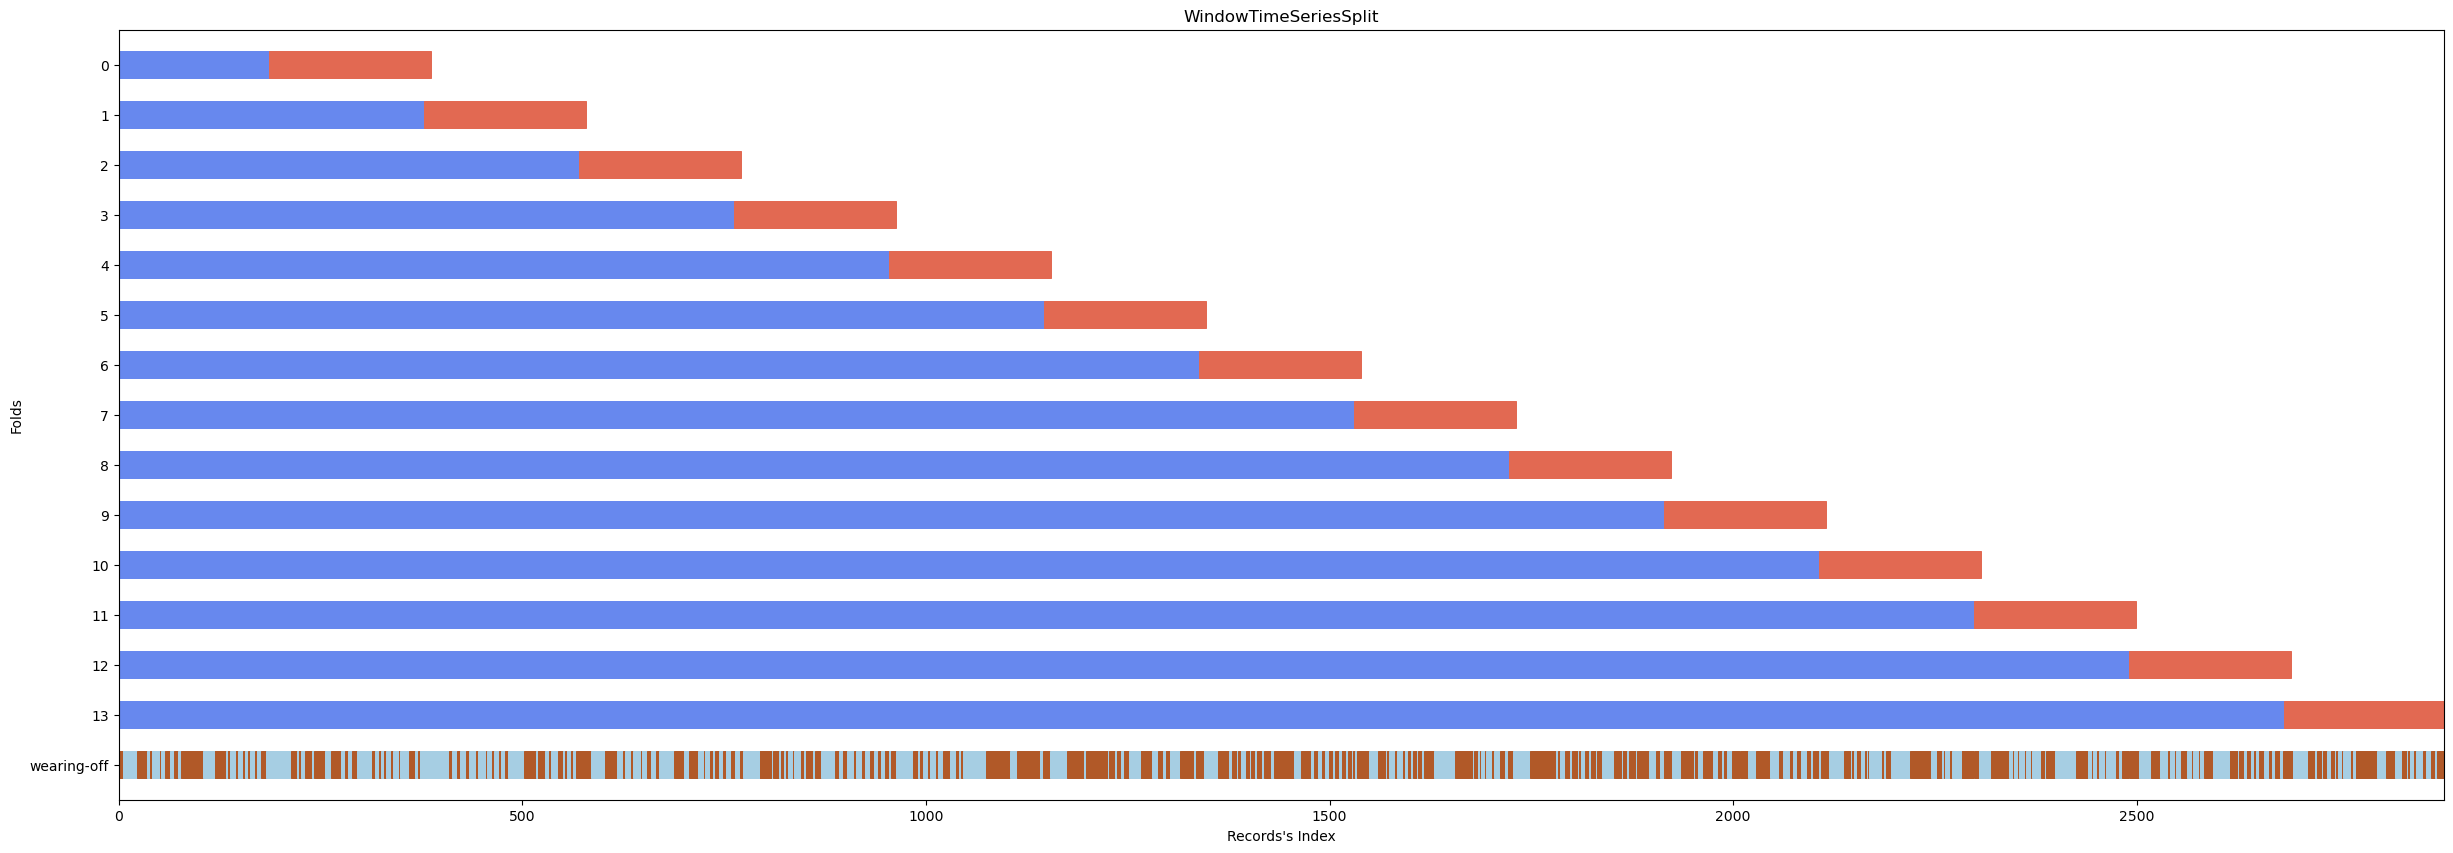

In [9]:
fig, ax = plt.subplots(figsize=FIGSIZE)
cv = WindowTimeSeriesSplit(
    RECORD_SIZE_PER_DAY * 2, RECORD_SIZE_PER_DAY * 2, True)
plot_cv_indices(
  cv,
  dataset.loc[:, dataset.columns != TARGET_COLUMN], dataset[[TARGET_COLUMN]],
  ax
)
plt.rc('text')  # , usetex=False)
plt.rc('font', family='serif')
plt.title('WindowTimeSeriesSplit')
plt.show()

## Split by train-test split

In [10]:
cv = WindowTimeSeriesSplit(
    RECORD_SIZE_PER_DAY * 2, RECORD_SIZE_PER_DAY * 2, True)
train_ix, test_ix = list(cv.split(
  dataset.loc[:, dataset.columns != TARGET_COLUMN],
  dataset[[TARGET_COLUMN]]
))[-1]

0 192 384
0 384 576
0 576 768
0 768 960
0 960 1152
0 1152 1344
0 1344 1536
0 1536 1728
0 1728 1920
0 1920 2112
0 2112 2304
0 2304 2496
0 2496 2688
0 2688 2880


In [11]:
train_df = dataset.iloc[train_ix].copy()
test_df = dataset.iloc[test_ix].copy()

# Transform series_to_supervised

In [12]:
# Convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  var_names = data.columns
  n_vars = len(var_names)
  df = pd.DataFrame(data)
  cols, names = list(), list()  # new column values, new columne names

  # input sequence (t-i, ... t-1)
  # timesteps before (e.g., n_in = 3, t-3, t-2, t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += list(
        map(lambda var_name: f'{var_name}(t-{i})', var_names)
    )

  # forecast sequence (t, t+1, ... t+n)
  # timesteps after (e.g., n_out = 3, t, t+1, t+2)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += list(map(lambda var_name: f'{var_name}(t)', var_names))
    else:
      names += list(map(lambda var_name: f'{var_name}(t+{i})', var_names))

  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names

  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)

  return agg

In [13]:
# Split into X and y
def split_x_y(df, target_columns, SHIFT=SHIFT):
  # Drop extra columns i.e., (t+1), (t+2), (t+3), (t+4)
  regex = r".*\(t\+[1-{SHIFT}]\)$"  # includes data(t)
  # regex = r"\(t(\+([1-{SHIFT}]))?\)$" # removes data(t)

  # Drop extra columns except target_columns
  df.drop(
    [x for x in df.columns if re.search(regex, x) and x not in target_columns],
    axis=1, inplace=True
  )

  # Split into X and y
  y = df[target_columns].copy()
  X = df.drop(target_columns, axis=1)

  return (X, y)

In [33]:
# For a similar sliding window with WindowGenerator,
#   n_in = last day, t - 47
#   n_out = next 1 hour
reframed_train_df = series_to_supervised(train_df,
                                         n_in=int(1 - 1),
                                         n_out=SHIFT + 1,
                                         dropnan=True)

train_X, train_y = split_x_y(reframed_train_df, [f'{TARGET_COLUMN}(t+{SHIFT})'])

display(train_y.head(5))
display(train_X.head(5))

,wearing_off(t+4)
timestamp,
2021-02-23 00:00:00,1.0
2021-02-23 00:15:00,1.0
2021-02-23 00:30:00,1.0
2021-02-23 00:45:00,1.0
2021-02-23 01:00:00,1.0


,heart_rate(t),steps(t),stress_score(t),awake(t),deep(t),light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),time_from_last_drug_taken(t),wo_duration(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t),wearing_off(t)
timestamp,,,,,,,,,,,,,,,,,,
2021-02-23 00:00:00,82.983333,13,47.0,8,32,156,67,188,255,0.737255,0.969582,0.0,0.0,0,1,-1.102015e-11,1.000000,1
2021-02-23 00:15:00,7.650000,0,-1.0,8,32,156,67,188,255,0.737255,0.969582,0.0,15.0,0,1,6.540313e-02,0.997859,1
2021-02-23 00:30:00,-1.000000,0,-1.0,8,32,156,67,188,255,0.737255,0.969582,0.0,30.0,0,1,1.305262e-01,0.991445,1
2021-02-23 00:45:00,-1.000000,0,-1.0,8,32,156,67,188,255,0.737255,0.969582,15.0,45.0,0,1,1.950903e-01,0.980785,1
2021-02-23 01:00:00,-1.000000,0,-1.0,8,32,156,67,188,255,0.737255,0.969582,30.0,60.0,1,1,2.588190e-01,0.965926,1


In [34]:
# For a similar sliding window with WindowGenerator,
#   n_in = last day, t - 47
#   n_out = next 1 hour
reframed_test_df = series_to_supervised(test_df,
                                        n_in=int(1 - 1),
                                        n_out=SHIFT + 1,
                                        dropnan=True)

test_X, test_y = split_x_y(reframed_test_df, [f'{TARGET_COLUMN}(t+{SHIFT})'])

display(test_y.head(5))
display(test_X.head(5))

,wearing_off(t+4)
timestamp,
2021-03-23 00:00:00,1.0
2021-03-23 00:15:00,1.0
2021-03-23 00:30:00,1.0
2021-03-23 00:45:00,1.0
2021-03-23 01:00:00,1.0


,heart_rate(t),steps(t),stress_score(t),awake(t),deep(t),light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),time_from_last_drug_taken(t),wo_duration(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t),wearing_off(t)
timestamp,,,,,,,,,,,,,,,,,,
2021-03-23 00:00:00,-1.0,0,-1.0,0,20,205,64,225,289,0.778547,1.0,160.0,40.0,0,1,-7.076388e-12,1.000000,1
2021-03-23 00:15:00,-1.0,0,-1.0,0,20,205,64,225,289,0.778547,1.0,175.0,55.0,0,1,6.540313e-02,0.997859,1
2021-03-23 00:30:00,-1.0,0,-1.0,0,20,205,64,225,289,0.778547,1.0,190.0,70.0,0,1,1.305262e-01,0.991445,1
2021-03-23 00:45:00,-1.0,0,-1.0,0,20,205,64,225,289,0.778547,1.0,205.0,85.0,0,1,1.950903e-01,0.980785,1
2021-03-23 01:00:00,-1.0,0,-1.0,0,20,205,64,225,289,0.778547,1.0,220.0,100.0,1,1,2.588190e-01,0.965926,1


# Scale features

In [35]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_X_scaled = scaler.fit_transform(train_X)
train_X_scaled = pd.DataFrame(train_X_scaled,
                              columns=train_X.columns,
                              index=train_X.index)

train_X_scaled.head(5)

,heart_rate(t),steps(t),stress_score(t),awake(t),deep(t),light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),time_from_last_drug_taken(t),wo_duration(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t),wearing_off(t)
timestamp,,,,,,,,,,,,,,,,,,
2021-02-23 00:00:00,0.582140,0.009811,0.495951,0.190476,0.154589,0.315972,0.380682,0.276882,0.442708,0.483761,0.873982,0.000000,0.000000,0.000000,0.166667,0.500000,1.000000,1.0
2021-02-23 00:15:00,0.059958,0.000000,0.010121,0.190476,0.154589,0.315972,0.380682,0.276882,0.442708,0.483761,0.873982,0.000000,0.020690,0.000000,0.166667,0.532702,0.998929,1.0
2021-02-23 00:30:00,0.000000,0.000000,0.010121,0.190476,0.154589,0.315972,0.380682,0.276882,0.442708,0.483761,0.873982,0.000000,0.041379,0.000000,0.166667,0.565263,0.995722,1.0
2021-02-23 00:45:00,0.000000,0.000000,0.010121,0.190476,0.154589,0.315972,0.380682,0.276882,0.442708,0.483761,0.873982,0.019608,0.062069,0.000000,0.166667,0.597545,0.990393,1.0
2021-02-23 01:00:00,0.000000,0.000000,0.010121,0.190476,0.154589,0.315972,0.380682,0.276882,0.442708,0.483761,0.873982,0.039216,0.082759,0.043478,0.166667,0.629410,0.982963,1.0


In [36]:
test_X_scaled = scaler.fit_transform(test_X)
test_X_scaled = pd.DataFrame(test_X_scaled,
                             columns=test_X.columns,
                             index=test_X.index)

test_X_scaled.head(5)

,heart_rate(t),steps(t),stress_score(t),awake(t),deep(t),light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),time_from_last_drug_taken(t),wo_duration(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t),wearing_off(t)
timestamp,,,,,,,,,,,,,,,,,,
2021-03-23 00:00:00,0.0,0.0,0.008457,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.244275,0.086957,0.000000,0.0,0.500000,1.000000,1.0
2021-03-23 00:15:00,0.0,0.0,0.008457,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.267176,0.119565,0.000000,0.0,0.532702,0.998929,1.0
2021-03-23 00:30:00,0.0,0.0,0.008457,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.290076,0.152174,0.000000,0.0,0.565263,0.995722,1.0
2021-03-23 00:45:00,0.0,0.0,0.008457,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.312977,0.184783,0.000000,0.0,0.597545,0.990393,1.0
2021-03-23 01:00:00,0.0,0.0,0.008457,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.335878,0.217391,0.043478,0.0,0.629410,0.982963,1.0


# Normalize features


In [37]:
normalizer = Normalizer()
train_X_scaled_normalized = normalizer.fit_transform(train_X_scaled)

train_X_scaled_normalized = pd.DataFrame(train_X_scaled_normalized,
                                         columns=train_X.columns,
                                         index=train_X.index)
train_X_scaled_normalized.head(5)

,heart_rate(t),steps(t),stress_score(t),awake(t),deep(t),light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),time_from_last_drug_taken(t),wo_duration(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t),wearing_off(t)
timestamp,,,,,,,,,,,,,,,,,,
2021-02-23 00:00:00,0.276328,0.004657,0.235416,0.090414,0.073380,0.149984,0.180700,0.131429,0.210143,0.229630,0.414858,0.000000,0.000000,0.000000,0.079113,0.237338,0.474676,0.474676
2021-02-23 00:15:00,0.030404,0.000000,0.005132,0.096588,0.078390,0.160225,0.193038,0.140403,0.224491,0.245309,0.443184,0.000000,0.010491,0.000000,0.084514,0.270125,0.506543,0.507086
2021-02-23 00:30:00,0.000000,0.000000,0.005115,0.096254,0.078119,0.159671,0.192371,0.139917,0.223715,0.244460,0.441651,0.000000,0.020910,0.000000,0.084222,0.285645,0.503170,0.505332
2021-02-23 00:45:00,0.000000,0.000000,0.005096,0.095893,0.077827,0.159073,0.191651,0.139393,0.222877,0.243545,0.439998,0.009871,0.031248,0.000000,0.083907,0.300828,0.498604,0.503441
2021-02-23 01:00:00,0.000000,0.000000,0.005076,0.095525,0.077528,0.158462,0.190915,0.138858,0.222022,0.242610,0.438308,0.019667,0.041504,0.021805,0.083585,0.315654,0.492963,0.501507


In [38]:
test_X_scaled_normalized = normalizer.fit_transform(test_X_scaled)

test_X_scaled_normalized = pd.DataFrame(test_X_scaled_normalized,
                                        columns=test_X.columns,
                                        index=test_X.index)
test_X_scaled_normalized.head(5)

,heart_rate(t),steps(t),stress_score(t),awake(t),deep(t),light(t),rem(t),nonrem_total(t),total(t),nonrem_percentage(t),sleep_efficiency(t),time_from_last_drug_taken(t),wo_duration(t),timestamp_hour(t),timestamp_dayofweek(t),timestamp_hour_sin(t),timestamp_hour_cos(t),wearing_off(t)
timestamp,,,,,,,,,,,,,,,,,,
2021-03-23 00:00:00,0.0,0.0,0.003126,0.0,0.369679,0.369679,0.369679,0.369679,0.369679,0.0,0.0,0.090303,0.032146,0.00000,0.0,0.184839,0.369679,0.369679
2021-03-23 00:15:00,0.0,0.0,0.003116,0.0,0.368420,0.368420,0.368420,0.368420,0.368420,0.0,0.0,0.098433,0.044050,0.00000,0.0,0.196258,0.368026,0.368420
2021-03-23 00:30:00,0.0,0.0,0.003105,0.0,0.367152,0.367152,0.367152,0.367152,0.367152,0.0,0.0,0.106502,0.055871,0.00000,0.0,0.207538,0.365582,0.367152
2021-03-23 00:45:00,0.0,0.0,0.003094,0.0,0.365878,0.365878,0.365878,0.365878,0.365878,0.0,0.0,0.114511,0.067608,0.00000,0.0,0.218629,0.362363,0.365878
2021-03-23 01:00:00,0.0,0.0,0.003083,0.0,0.364556,0.364556,0.364556,0.364556,0.364556,0.0,0.0,0.122446,0.079251,0.01585,0.0,0.229455,0.358345,0.364556


# Train model

In [46]:
# create model instance
xgb_model = XGBClassifier()

# fit model
xgb_model.fit(train_X_scaled_normalized, train_y)

# make predictions
preds = xgb_model.predict(test_X_scaled_normalized)
# Get the probability for 1s class
preds_proba = xgb_model.predict_proba(test_X_scaled_normalized)[:, 1]

In [47]:
test_y.values.ravel()

array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1.])

In [48]:
preds

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1])

In [49]:
preds_proba

array([0.51879925, 0.26665998, 0.25131023, 0.24275813, 0.19824618,
       0.13340978, 0.03408761, 0.01088472, 0.01378465, 0.00699231,
       0.00261389, 0.00261389, 0.00256371, 0.00128775, 0.00129359,
       0.00364533, 0.0238502 , 0.05726516, 0.08166188, 0.1425239 ,
       0.6765707 , 0.6506778 , 0.7811185 , 0.96993893, 0.99556315,
       0.9950654 , 0.99452823, 0.99586535, 0.99559844, 0.98682135,
       0.97307384, 0.9616104 , 0.9786709 , 0.9795681 , 0.5989725 ,
       0.68127567, 0.568145  , 0.6082921 , 0.8073049 , 0.7899596 ,
       0.9263893 , 0.76464677, 0.74690485, 0.83932376, 0.97689223,
       0.97418517, 0.9109395 , 0.9740726 , 0.8553038 , 0.6084559 ,
       0.9471965 , 0.96302265, 0.9612223 , 0.96634465, 0.947422  ,
       0.9767446 , 0.9876302 , 0.8672999 , 0.9009358 , 0.8603085 ,
       0.67822325, 0.9367707 , 0.71760213, 0.8715434 , 0.7937318 ,
       0.9155511 , 0.7717773 , 0.7927639 , 0.7046371 , 0.35749644,
       0.64700955, 0.3403652 , 0.95102   , 0.76782376, 0.61621

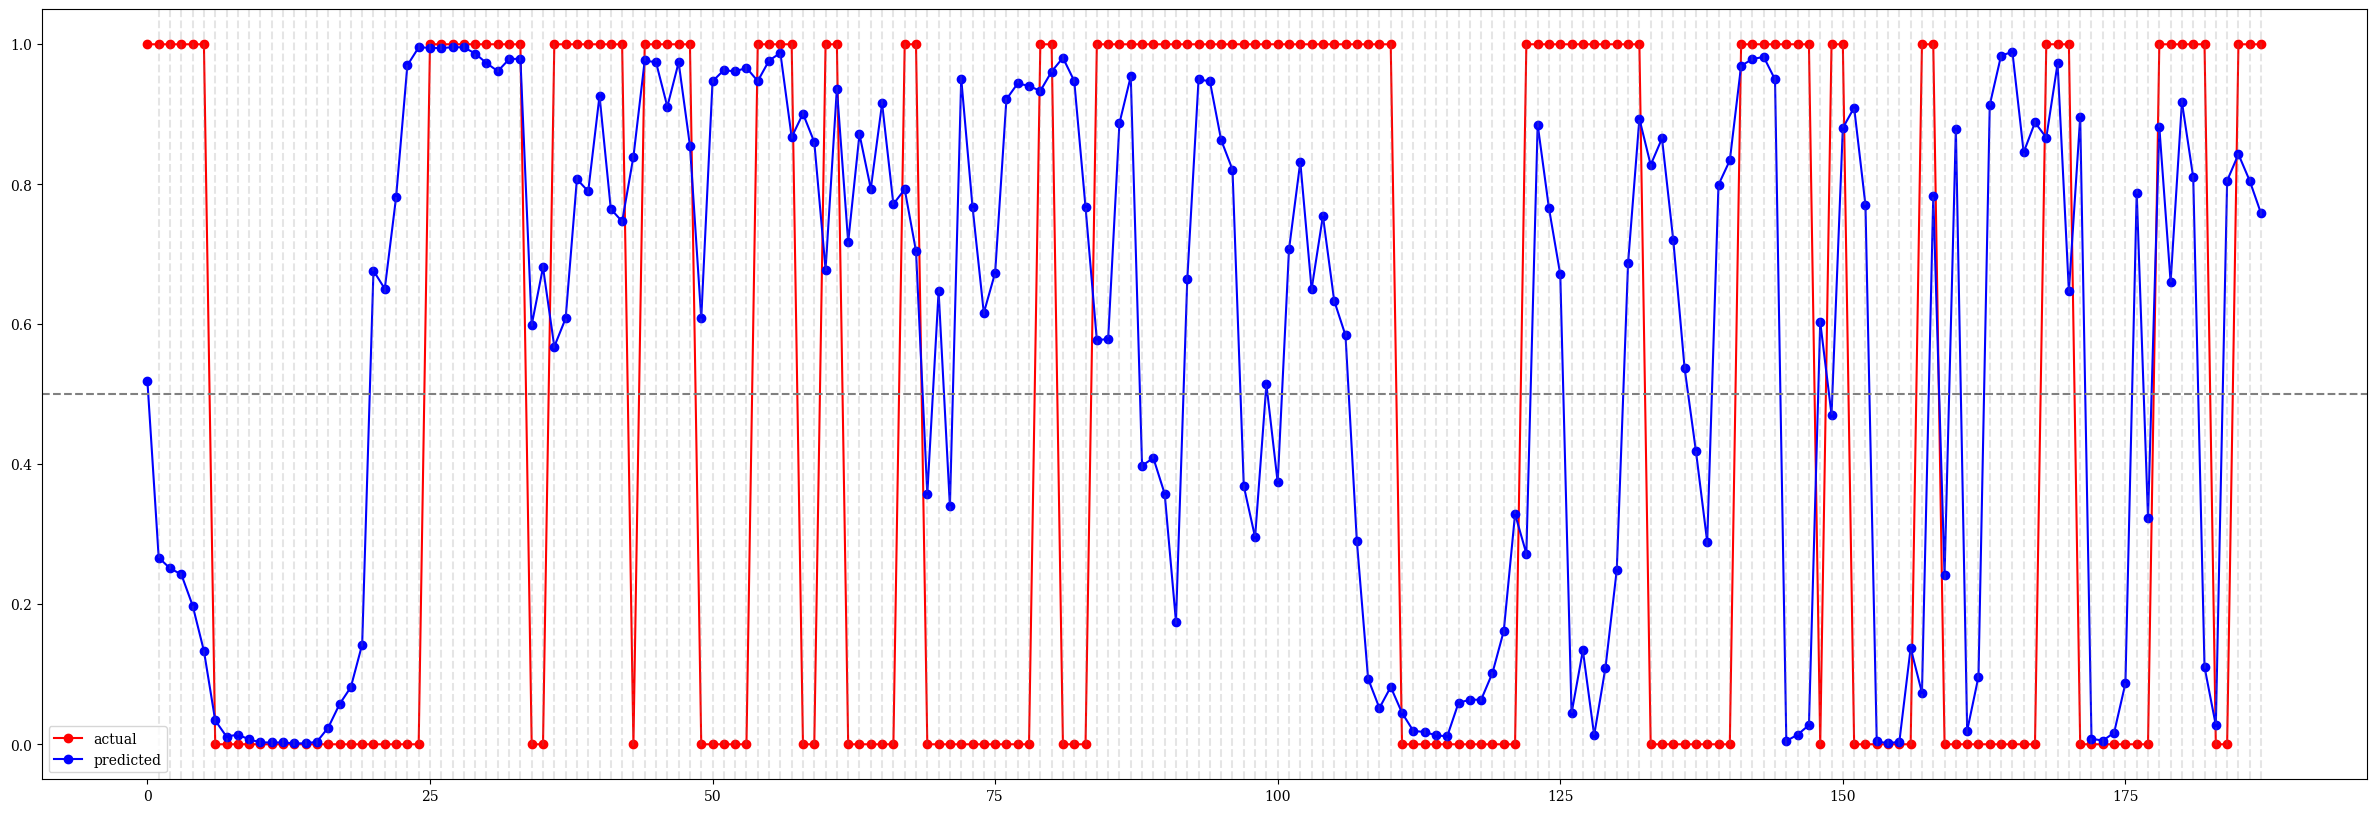

In [50]:
# Plot `test_y.values.ravel()` and `preds_proba` on the same plot to show the difference
plt.figure(figsize=FIGSIZE)
plt.plot(test_y.values.ravel(), label='actual', color='red', marker='o')
plt.plot(preds_proba, label='predicted', color='blue', marker='o')
plt.legend()

# Add dashed horizontal line at 0.5
plt.axhline(0.5, linestyle='--', color='gray')

# Add dashed vertical lines on each time
for i in range(1, len(test_y)):
  plt.axvline(i, linestyle='--', color='gray', alpha=0.2)

plt.show()

In [52]:
# evaluate predictions with f1 score, precision, recall, and accuracy
import sklearn.metrics as metrics

print('f1 score:', metrics.f1_score(test_y.values.ravel(), preds))
print('precision:', metrics.precision_score(test_y.values.ravel(), preds))
print('recall:', metrics.recall_score(test_y.values.ravel(), preds))
print('accuracy:', metrics.accuracy_score(test_y.values.ravel(), preds))

f1 score: 0.6418604651162791
precision: 0.5847457627118644
recall: 0.711340206185567
accuracy: 0.5904255319148937
